In [16]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time

In [17]:
def fX(alphas, X, i, Y, b):
    return float(np.multiply(alphas, Y).T * (X * X[i,:].T) + b)

In [18]:
def selectJRandomly(i, m):
    j = i
    while (j == i):
        j = int(random.uniform(0, m))
    return j

In [19]:
def clipAlphaJ(aj, H, L):
    if aj > H:
        aj = H
    if aj < L:
        aj = L
    return aj

In [20]:
def computeW(alphas, dataX, classY):
    X = np.mat(dataX)
    Y = np.mat(classY).T
    m, n = np.shape(X)
    w = np.zeros((n, 1))
    for i in range(m):
        w += np.multiply(alphas[i] * Y[i], X[i,:].T)
    return w

In [21]:
def computeEta(X, i, j):
    return 2.0 * X[i,:] * X[j,:].T - X[i,:] * X[i,:].T - X[j,:] * X[j,:].T

In [22]:
def predictedClass(point, w, b):
    p = np.mat(point)
    f = p * w + b
    if f > 0:
        print(point, "belongs to Class 1")
    else:
        print(point, "belongs to Class -1")

In [23]:
def simplifiedSMO(dataX, classY, C, tol, max_passes):
    X = np.mat(dataX)
    Y = np.mat(classY).T
    m, n = np.shape(X)

    # Initializam b: threshold pentru solutie
    b = 0
    # Initializam alphas: multiplicatorii Lagrange pentru solutie
    alphas = np.mat(np.zeros((m, 1)))
    passes = 0
    while (passes < max_passes):
        print(passes, max_passes)
        num_changed_alphas = 0
        for i in range(m):
            # Calculam Ei = f(xi) - yi
            fXi = fX(alphas, X, i, Y, b)
            Ei = fXi - float(Y[i])
            # https://ro.wikipedia.org/wiki/Condi%C8%9Biile_Karush-Kuhn-Tucker
            if ((Y[i] * Ei < -tol) and (alphas[i] < C)) or ((Y[i] * Ei > tol) and (alphas[i] > 0)):
                # avand un alpha[i] care nu respecta conditiile teoremei KKT, luam random un j si incercam sa optimizam alpha[i] si alpha[j]
                j = selectJRandomly(i, m)
                if i == j:
                    continue

                # Calculam Ej = f(xj) - yj
                fXj = fX(alphas, X, j, Y, b)
                Ej = fXj - float(Y[j])

                # salvam temporar alpha-urile vechi
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()
                # calculam L si H
                if (Y[i] != Y[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])

                # daca L = H, atunci continua algoritmul in cautarea unui alt i
                if L == H:
                    continue
    
                # calculam eta-ul
                eta = computeEta(X, i, j)

                # daca eta >= 0, atunci continua algoritmul in cautarea unui alt i
                if eta >= 0:
                    continue

                # eta fiind < 0, calculam alpha-urile noi obtinute
                alphas[j] -= Y[j] * (Ei - Ej) / eta

                # trunchiem valoarea noua a lui alpha intre L si H
                alphas[j] = clipAlphaJ(alphas[j], H, L)

                # daca diferenta este sub o eroare definita (e.g. 10^-5), atunci continua algoritmul in cautarea unui alt i
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    continue
  
                # determinam valoarea pentru alpha[i]
                alphas[i] += Y[j] * Y[i] * (alphaJold - alphas[j])

                # calculam b1 si b2
                b1 = b - Ei - Y[i] * (alphas[i] - alphaIold) * X[i,:] * X[i,:].T - Y[j] * (alphas[j] - alphaJold) * X[i,:] * X[j,:].T
                b2 = b - Ej - Y[i] * (alphas[i] - alphaIold) * X[i,:] * X[j,:].T - Y[j] * (alphas[j] - alphaJold) * X[j,:] * X[j,:].T

                # calculam valoarea bias-ului b
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2) / 2.0                 
                    print('bau8')
                num_changed_alphas += 1
        if (num_changed_alphas == 0):
            passes += 1
        else:
            passes = 0
    return alphas, b

In [28]:
def loadDataSet(fileName):
    dataX = []
    labelY = []
    fr = open(fileName)
    for r in fr.readlines():
        record = r.strip().split()
        dataX.append([float(record[0]), float(record[1])])
        labelY.append(float(record[2]))
    return dataX, labelY

In [29]:
def plotLinearClassifier(point, w, alphas, b, dataX, labelY):
    np.shape(alphas[alphas>0])
    
    Y = np.array(labelY)
    X = np.array(dataX)
    svmMat = []
    alphaMat = []
    for i in range(Y.shape[0]):
        alphaMat.append(alphas[i])
        if alphas[i]>0.0:
            svmMat.append(X[i])
                                
    svmPoints = np.array(svmMat)
    alphasArr = np.array(alphaMat)

    numofSVMs = np.shape(svmPoints)[0]
    print("Number of SVM points: %d" % numofSVMs)

    xSVM = []
    ySVM = []
    for i in range(numofSVMs):
        xSVM.append(svmPoints[i,0])
        ySVM.append(svmPoints[i,1])    
    
    n = np.shape(X)[0]    
    xcord1 = []
    ycord1 = []
    xcord2 = []
    ycord2 = []
    
    for i in range(n):
        if int(labelY[i])== 1:
            xcord1.append(X[i,0])
            ycord1.append(X[i,1])                  
        else:
            xcord2.append(X[i,0])
            ycord2.append(X[i,1])                  

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=100, c='purple', marker='s')
    
    ax.scatter(xcord2, ycord2, s=100, c='orange')
    
    red_patch = mpatches.Patch(color='purple', label='Class 1')
    green_patch = mpatches.Patch(color='orange', label='Class -1')
    plt.legend(handles=[red_patch,green_patch])
    
    x_min = min(point[0], min(dataX, key=lambda t: t[0])[0])
    x_max = max(point[0], max(dataX, key=lambda t: t[0])[0])
    
    x = []
    y = []
    for xfit in np.linspace(x_min, x_max):
        x.append(xfit)
        y.append(float((-w[0]/w[1])*xfit - b[0, 0] / w[1] ))
            
    ax.plot(x,y, color='green')
    
    predictedClass(point,w,b)
    p = np.mat(point)
    ax.scatter(p[0,0], p[0,1], s=30, c='black', marker='s')
    circle1=plt.Circle((p[0,0],p[0,1]),0.6, color='b', fill=False)
    plt.gcf().gca().add_artist(circle1)
    
    plt.show()

In [36]:
X, Y = loadDataSet('./dataset/dataset2.txt')
print (X, Y)

start = time.time()
alphas, b = simplifiedSMO(X, Y, 0.0001, 0.001, 40)
end = time.time()
print("------------TIME---------------")
print(end - start)
w = computeW(alphas, X, Y)

print (alphas,'\n', w, '\n', b)

[[-194.0, 61.0], [-197.0, 28.0], [-169.0, 37.0], [-155.0, 87.0], [-123.0, 89.0], [-113.0, 62.0], [-69.0, 31.0], [-144.0, 20.0], [-178.0, -6.0], [-235.0, -26.0], [-164.0, -49.0], [-247.0, -90.0], [-309.0, -95.0], [-247.0, -170.0], [-169.0, -87.0], [-208.0, -65.0], [-198.0, -125.0], [-176.0, -166.0], [-112.0, -143.0], [-80.0, -113.0], [-42.0, -84.0], [-41.0, -22.0], [-49.0, 5.0], [-58.0, 13.0], [-112.0, 2.0], [-120.0, -36.0], [-102.0, 239.0], [-119.0, 246.0], [-147.0, 223.0], [-115.0, 135.0], [32.0, 161.0], [5.0, 83.0], [-8.0, 87.0], [-2.0, -82.0], [-16.0, -97.0], [-46.0, -120.0], [-25.0, -159.0], [-2.0, -134.0], [25.0, -105.0], [53.0, -29.0], [40.0, 32.0], [18.0, -18.0], [45.0, -53.0], [75.0, 7.0], [65.0, 77.0], [30.0, 99.0], [16.0, 128.0], [-16.0, 119.0], [-28.0, 74.0], [-33.0, 43.0], [-69.0, 52.0], [-88.0, -15.0], [-60.0, -56.0], [-87.0, -67.0], [-301.0, -171.0], [-305.0, -129.0], [113.0, 186.0], [92.0, 142.0], [105.0, 116.0], [146.0, -176.0], [71.0, -211.0], [209.0, -236.0], [232.0, 

Number of SVM points: 19
[1, 3] belongs to Class -1


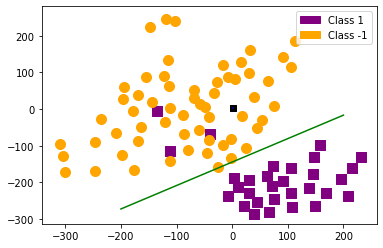

In [37]:
test_point = [1,3]
plotLinearClassifier(test_point, w, alphas, b, X, Y)